In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

In [52]:
sns.set_style("whitegrid")

DATA_FILE = '/Users/annie_lok_yan_wong/Downloads/european_wholesale_electricity_price_data_hourly/For_merging/final_merged/complete_data_only.csv'
OUTPUT_DIR = '/Users/annie_lok_yan_wong/Downloads/european_wholesale_electricity_price_data_hourly/For_merging/data_aggregation'

df = pd.read_csv(DATA_FILE)

In [54]:
def aggregate_by_country(df):
    agg_functions = {
        # Price features
        'price': ['mean', 'median', 'std', 'min', 'max'],
        # Carbon-free features  
        'carbon_free_pct': ['mean', 'median', 'std', 'min', 'max'],
        # Count
        'timestamp': 'count'
    }
    
    # Add renewable_pct if available
    if 'renewable_pct' in df.columns:
        agg_functions['renewable_pct'] = ['mean', 'std']
    
    # Aggregate
    country_df = df.groupby('zone').agg(agg_functions).reset_index()
    
    # Flatten column names
    country_df.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                          for col in country_df.columns.values]
    
    # Rename for clarity
    country_df = country_df.rename(columns={
        'timestamp_count': 'n_observations',
        'price_mean': 'avg_price',
        'price_std': 'price_volatility',
        'carbon_free_pct_mean': 'avg_carbon_free',
        'carbon_free_pct_std': 'carbon_free_volatility'
    })
    
    # Add derived features
    country_df['price_range'] = country_df['price_max'] - country_df['price_min']
    country_df['price_cv'] = country_df['price_volatility'] / country_df['avg_price']
    country_df['cf_range'] = country_df['carbon_free_pct_max'] - country_df['carbon_free_pct_min']
    
    # Calculate negative price percentage
    neg_price_pct = df[df['price'] < 0].groupby('zone').size() / df.groupby('zone').size() * 100
    country_df['negative_price_pct'] = country_df['zone'].map(neg_price_pct).fillna(0)
    
    # Add country names
    country_map = df.groupby('zone')['country'].first()
    country_df['country'] = country_df['zone'].map(country_map)
    
    return country_df

country_df = aggregate_by_country(df)

In [55]:
country_df.head()

,zone,avg_price,price_median,price_volatility,price_min,price_max,avg_carbon_free,carbon_free_pct_median,carbon_free_volatility,carbon_free_pct_min,carbon_free_pct_max,n_observations,renewable_pct_mean,renewable_pct_std,price_range,price_cv,cf_range,negative_price_pct,country
0,AT,91.639397,90.895,45.291189,-270.42,711.69,85.185899,88.285,11.804502,44.72,99.82,17544,80.469048,13.386743,982.11,0.494233,55.10,1.909485,Austria
1,BE,83.777638,85.770,46.476229,-140.00,565.46,75.286626,78.825,11.675843,35.47,94.93,17544,34.283109,14.049253,705.46,0.554757,59.46,3.562472,Belgium
2,CH,91.682645,91.030,42.733723,-427.51,310.64,96.498677,98.200,4.022580,72.74,99.70,17544,64.281999,9.584455,738.15,0.466105,26.96,2.097583,Switzerland
3,CZ,92.937053,93.010,48.607121,-138.75,844.63,54.628689,53.780,10.149919,32.91,85.53,17544,17.491439,9.165953,983.38,0.523011,52.62,2.559280,Czechia
4,DE,86.441628,88.085,48.546017,-316.40,808.87,64.449829,65.965,14.537197,22.70,91.46,17544,59.881969,15.678677,1125.27,0.561605,68.76,3.305974,Germany


In [56]:
print(f"Number of countries: {len(country_df)}")
print(f"Data shape: {country_df.shape}")
print(country_df[['zone', 'avg_carbon_free', 'avg_price']].head())

Number of countries: 20
Data shape: (20, 19)
  zone  avg_carbon_free  avg_price
0   AT        85.185899  91.639397
1   BE        75.286626  83.777638
2   CH        96.498677  91.682645
3   CZ        54.628689  92.937053
4   DE        64.449829  86.441628


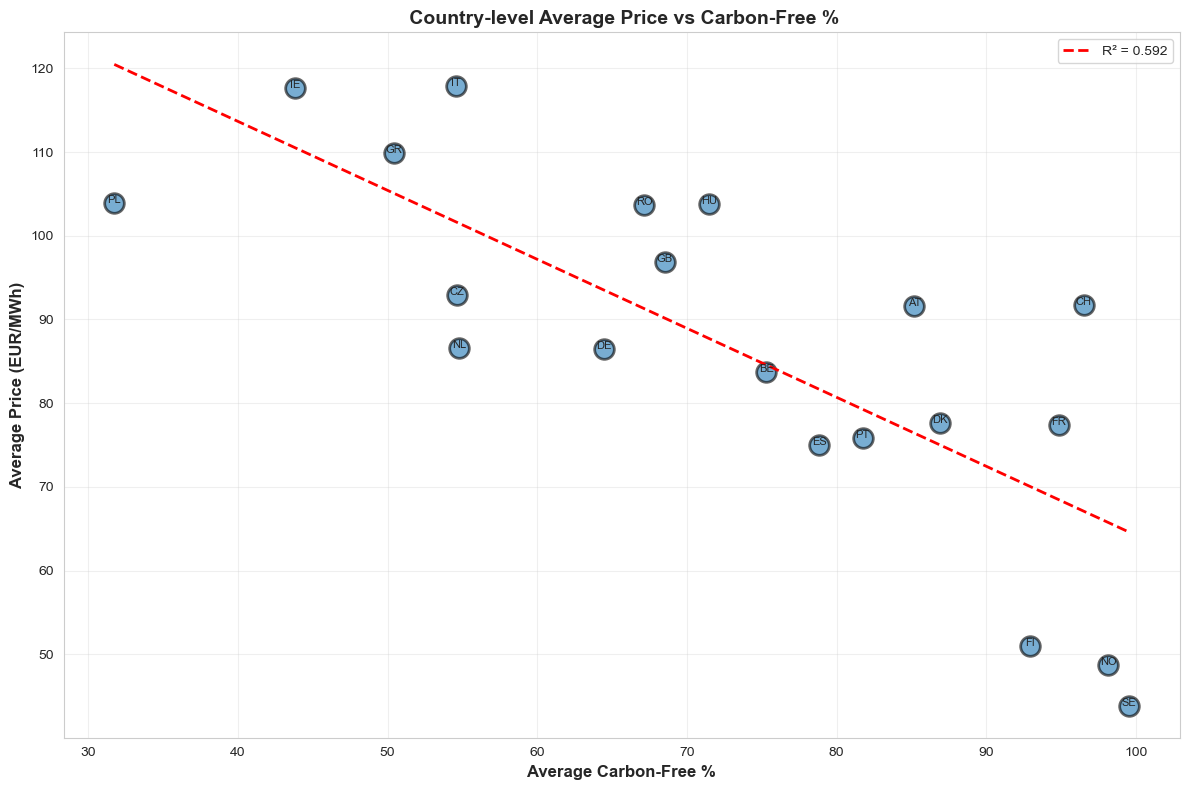

In [57]:
def visualize_aggregations(country_df):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Country-level scatter
    ax1.scatter(country_df['avg_carbon_free'], country_df['avg_price'], 
                s=200, alpha=0.6, edgecolors='black', linewidth=2)
    
    # Add country labels
    for _, row in country_df.iterrows():
        ax1.annotate(row['zone'], 
                     (row['avg_carbon_free'], row['avg_price']),
                     fontsize=8, ha='center')
    
    # Fit regression
    X = country_df[['avg_carbon_free']].values
    y = country_df['avg_price'].values
    model = LinearRegression().fit(X, y)
    
    # Create line
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot line
    ax1.plot(x_line, y_line, 'r--', linewidth=2, 
             label=f'R² = {model.score(X, y):.3f}')
    
    ax1.legend()
    ax1.set_xlabel('Average Carbon-Free %', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Average Price (EUR/MWh)', fontweight='bold', fontsize=12)
    ax1.set_title(f' Country-level Average Price vs Carbon-Free %', 
                  fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 

visualize_aggregations(country_df)

In [60]:
import statsmodels.api as sm
X = country_df['avg_carbon_free']
y = country_df['avg_price']
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     26.12
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           7.31e-05
Time:                        17:37:01   Log-Likelihood:                -79.948
No. Observations:                  20   AIC:                             163.9
Df Residuals:                      18   BIC:                             165.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             146.6347     12.110     

In [61]:
features = ['avg_price', 'price_volatility', 'avg_carbon_free', 
            'carbon_free_volatility', 'renewable_pct_mean', 'negative_price_pct']

X = country_df[features].values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
country_df['cluster'] = kmeans.fit_predict(X_scaled)

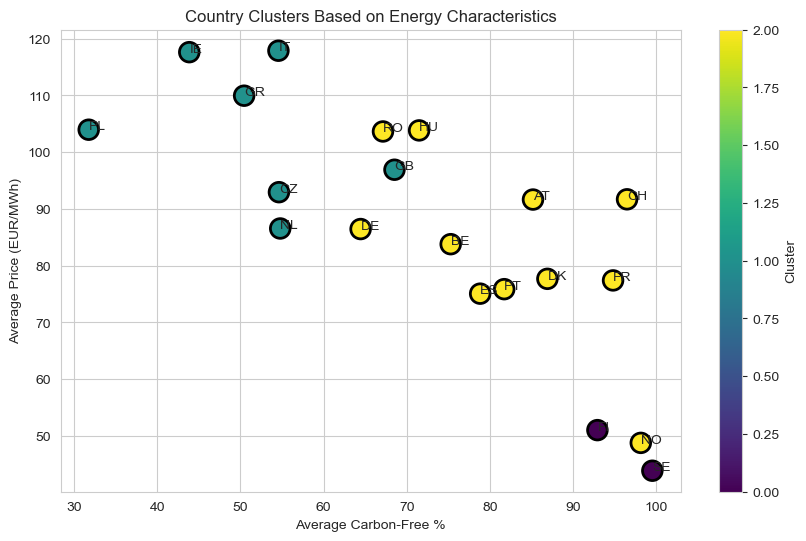

In [62]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(country_df['avg_carbon_free'], country_df['avg_price'], 
                     c=country_df['cluster'], cmap='viridis', s=200, 
                     edgecolors='black', linewidth=2)
for _, row in country_df.iterrows():
    plt.annotate(row['zone'], (row['avg_carbon_free'], row['avg_price']))
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Average Carbon-Free %')
plt.ylabel('Average Price (EUR/MWh)')
plt.title('Country Clusters Based on Energy Characteristics')
plt.show()

In [63]:
features = ['avg_price', 'price_volatility', 'avg_carbon_free', 
            'carbon_free_volatility', 'renewable_pct_mean', 
            'negative_price_pct', 'price_cv', 'cf_range']

X = country_df[features].values
zone_labels = country_df['zone'].values

# Step 1: Standardize features (crucial!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [38]:
print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"PCA dimensions: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Original dimensions: 8
PCA dimensions: 4
Variance explained: 95.75%


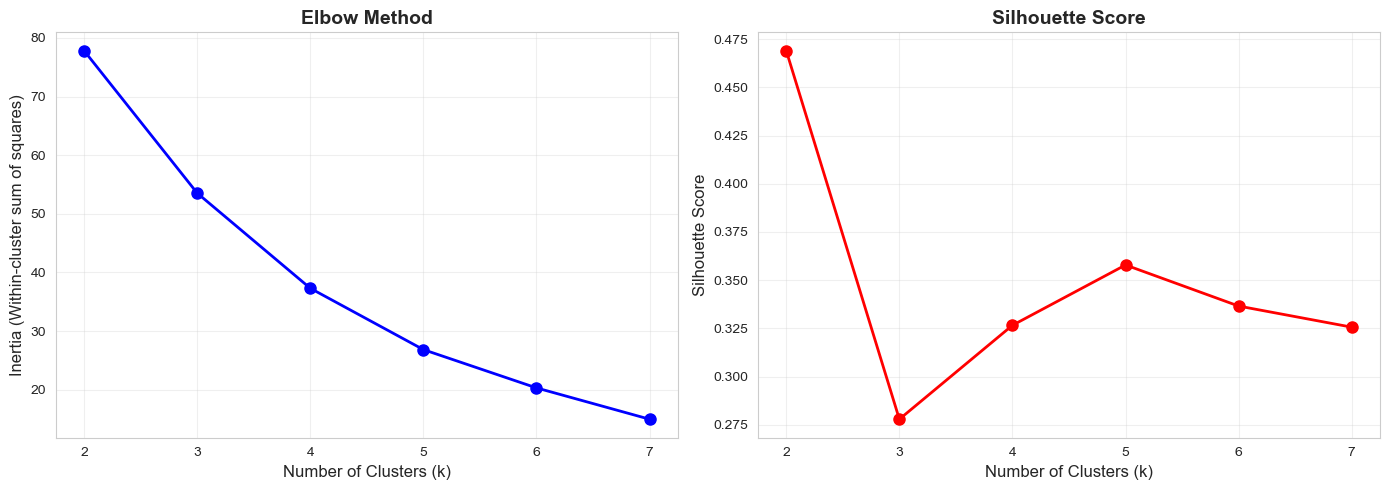

In [42]:
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/xs/rltwwntj3gl2rcygzw0mbmch0000gn/T/ipykernel_79462/1816446249.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


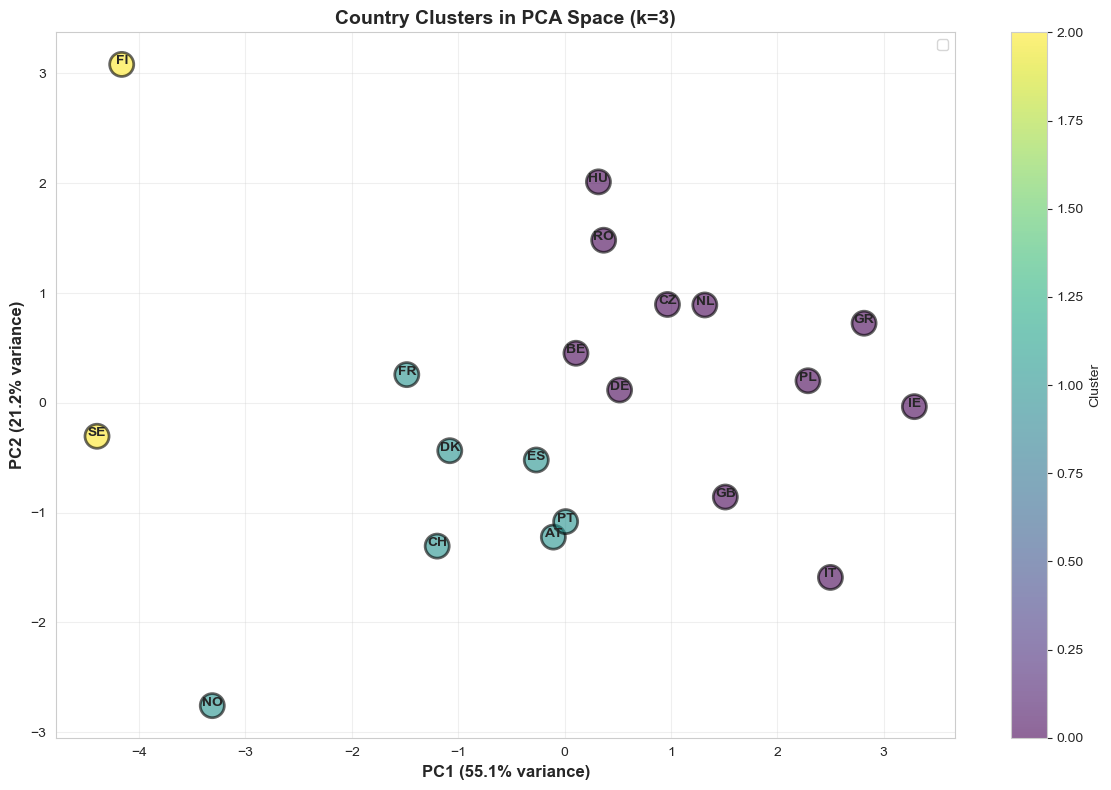

In [64]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

country_df['cluster'] = clusters

plt.figure(figsize=(12, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters, cmap='viridis', s=300, 
                     alpha=0.6, edgecolors='black', linewidth=2)

for i, zone in enumerate(zone_labels):
    plt.annotate(zone, (X_pca[i, 0], X_pca[i, 1]), 
                fontsize=10, ha='center', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.title(f'Country Clusters in PCA Space (k={optimal_k})', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
country_mapping = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'CH': 'Switzerland',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',
    'GR': 'Greece',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IT': 'Italy',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia'
}

country_df['country'] = country_df['zone'].map(country_mapping)

chart_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Zone': zone_labels,  
    'Country': country_df['country'].values, 
    'Cluster': clusters.astype(str)
})

import altair as alt
chart = alt.Chart(chart_data).mark_circle(
    size=300,
    opacity=0.6,
    stroke='black',
    strokeWidth=2
).encode(
    x=alt.X('PC1:Q', 
            title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
            scale=alt.Scale(zero=False)),
    y=alt.Y('PC2:Q', 
            title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
            scale=alt.Scale(zero=False)),
    color=alt.Color('Cluster:N', 
                    scale=alt.Scale(scheme='viridis'),
                    legend=alt.Legend(title='Cluster')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Zone:N', title='Zone Code'),
        alt.Tooltip('Cluster:N', title='Cluster'),
        alt.Tooltip('PC1:Q', title='PC1', format='.2f'),
        alt.Tooltip('PC2:Q', title='PC2', format='.2f')
    ]
).properties(
    width=600,
    height=500,
    title=f'Country Clusters in PCA Space (k={optimal_k})'
)

text = chart.mark_text(
    align='center',
    baseline='middle',
    fontSize=10,
    fontWeight='bold',
    dy=0
).encode(
    text='Zone:N',
    color=alt.value('black')
)

final_chart = (chart + text).interactive()

final_chart.display()
final_chart.save('country_cluster_interactive.json')

alt.LayerChart(...)

In [65]:
print("\n" + "="*60)
for cluster_id in range(optimal_k):
    cluster_countries = country_df[country_df['cluster'] == cluster_id]
    print(f"\n CLUSTER {cluster_id} (n={len(cluster_countries)})")
    print(f"Countries: {', '.join(cluster_countries['zone'].values)}")
    
    for feature in features:
        mean_val = cluster_countries[feature].mean()
        print(f"{feature}: {mean_val:.2f}")

print("\n" + "="*60)
print("="*60)

for i in range(min(3, X_pca.shape[1])):  # First 3 PCs
    print(f"\n PC{i+1} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
    loadings = pca.components_[i]
    feature_importance = pd.DataFrame({
        'feature': features,
        'loading': loadings,
        'abs_loading': np.abs(loadings)
    }).sort_values('abs_loading', ascending=False)
    
    for _, row in feature_importance.head(3).iterrows():
        direction = "↑" if row['loading'] > 0 else "↓"
        print(f"  {direction} {row['feature']}: {row['loading']:.3f}")




 CLUSTER 0 (n=11)
Countries: BE, CZ, DE, GB, GR, HU, IE, IT, NL, PL, RO
avg_price: 100.31
price_volatility: 50.72
avg_carbon_free: 57.90
carbon_free_volatility: 13.81
renewable_pct_mean: 41.06
negative_price_pct: 1.80
price_cv: 0.51
cf_range: 66.45

 CLUSTER 1 (n=7)
Countries: AT, CH, DK, ES, FR, NO, PT
avg_price: 76.87
price_volatility: 43.83
avg_carbon_free: 88.88
carbon_free_volatility: 7.51
renewable_pct_mean: 68.73
negative_price_pct: 2.00
price_cv: 0.58
cf_range: 42.63

 CLUSTER 2 (n=2)
Countries: FI, SE
avg_price: 47.44
price_volatility: 53.06
avg_carbon_free: 96.24
carbon_free_volatility: 2.62
renewable_pct_mean: 61.22
negative_price_pct: 6.19
price_cv: 1.10
cf_range: 16.94


 PC1 (explains 55.1% variance):
  ↑ avg_price: 0.439
  ↓ avg_carbon_free: -0.422
  ↑ cf_range: 0.413

 PC2 (explains 21.2% variance):
  ↑ price_volatility: 0.674
  ↓ renewable_pct_mean: -0.467
  ↑ price_cv: 0.423

 PC3 (explains 11.1% variance):
  ↑ carbon_free_volatility: 0.520
  ↑ cf_range: 0.480
  ↑ r

In [74]:
X = country_df[['avg_carbon_free']].values
y = country_df['avg_price'].values
model = LinearRegression().fit(X, y)
r2_score = model.score(X, y)

scatter_data = pd.DataFrame({
    'avg_carbon_free': country_df['avg_carbon_free'],
    'avg_price': country_df['avg_price'],
    'zone': country_df['zone'],
    'country': country_df['country']
})

x_line = np.linspace(X.min(), X.max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
line_data = pd.DataFrame({'avg_carbon_free': x_line, 'avg_price': y_line})

scatter = alt.Chart(scatter_data).mark_circle(
    size=200, opacity=0.6, stroke='black', strokeWidth=2
).encode(
    x=alt.X('avg_carbon_free:Q', title='Average Carbon-Free %', scale=alt.Scale(zero=False)),
    y=alt.Y('avg_price:Q', title='Average Price (EUR/MWh)', scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('zone:N', title='Zone'),
        alt.Tooltip('avg_carbon_free:Q', title='Avg Carbon-Free %', format='.2f'),
        alt.Tooltip('avg_price:Q', title='Avg Price (EUR/MWh)', format='.2f')
    ]
)

text = scatter.mark_text(align='center', baseline='middle', fontSize=8, dy=0).encode(
    text='zone:N', color=alt.value('black')
)

line = alt.Chart(line_data).mark_line(color='red', strokeDash=[5, 5], strokeWidth=2).encode(
    x='avg_carbon_free:Q', y='avg_price:Q'
)

r2_annotation = alt.Chart(pd.DataFrame({
    'x': [X.max()], 'y': [y.max()], 'label': [f'R² = {r2_score:.3f}']
})).mark_text(align='right', baseline='top', fontSize=12, fontWeight='bold', 
              dx=-10, dy=10, color='red').encode(x='x:Q', y='y:Q', text='label:N')

chart = (scatter + text + line + r2_annotation).properties(
    width=700, height=500, title='Country-level Average Price vs Carbon-Free %'
).configure_title(fontSize=14, fontWeight='bold').configure_axis(
    labelFontSize=11, titleFontSize=12, titleFontWeight='bold'
).interactive()

chart
chart.save('price_vs_carbonfree_interactive.json')